## imports

In [2]:
from patterns.default_patterns import LABEL_MAP, RELEVANT_LABELS, DEFAULT_PATTERNS
from data.ai4privacy.pii_masking_200k import load_pii_dataset
from evaluation.metrics import compute_metrics, print_metrics
from evaluation.evaluator import evaluate_dataset
from classes.pii_detector import PIIDetector

C:\Anass_de_programmeur\School\Reflect_Audio_Journaling\Research\PII\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## overview

This notebook evaluates a PII-detection pipeline built on top of spaCy’s Dutch model (nl_core_news_lg). Unlike the English pipeline, this model does not use a transformer. It relies on spaCy’s tok2vec architecture, which encodes tokens with significantly less contextual information. My working hypothesis is that this reduced contextual understanding will lead to lower performance, especially for entities that depend on sentence-level meaning (e.g., PERSON, ORG, GPE).

The detector uses two components:

- NER-based detection for unstructured entities such as PERSON, ORG, GPE, and DATE.
- Regex-based detection for structured patterns such as EMAIL, PHONENUMBER, and ZIPCODE.

These categories cover the types of sensitive information that realistically appear in journaling: names, places, dates, and contact details.

The pipeline provides two main functions:

- detect(text) returns the detected PII items, their labels, and their character positions.
- redact(text) returns the same text with each detected entity replaced by [REDACTED:<LABEL>].

In this notebook, the goal is to assess how well the Dutch tok2vec-based detector performs. First, it is evaluated on a non-synthetic PII dataset to obtain a broad baseline (keeping in mind that many labels in that dataset fall outside the scope of this detector). Next, small self-written journal examples are used to verify whether the detector behaves correctly in realistic journaling scenarios. Finally, the pipeline is tested on a synthetic dataset intentionally designed to mimic real Dutch journal entries.

This process shows how the Dutch model performs both in general evaluation and in the specific context it is intended for.

## loading dataset and model

In [19]:
import spacy
nlp = spacy.load("nl_core_news_lg")
print(nlp.get_pipe("ner").labels)

('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')


In [6]:
ds = load_pii_dataset(split="train")
detector = PIIDetector(model="nl_core_news_lg")

## exploring dataset labels

The dataset has a lot of labels, a lot of them are not relevant for our usecase of PII detection.


In [7]:
all_labels = set()
for example in ds:
    for mask in example["privacy_mask"]:
        all_labels.add(mask["label"])

print(sorted(all_labels))
print(f"\nTotal unique labels: {len(all_labels)}")

['ACCOUNTNAME', 'ACCOUNTNUMBER', 'AGE', 'AMOUNT', 'BIC', 'BITCOINADDRESS', 'BUILDINGNUMBER', 'CITY', 'COMPANYNAME', 'COUNTY', 'CREDITCARDCVV', 'CREDITCARDISSUER', 'CREDITCARDNUMBER', 'CURRENCY', 'CURRENCYCODE', 'CURRENCYNAME', 'CURRENCYSYMBOL', 'DATE', 'DOB', 'EMAIL', 'ETHEREUMADDRESS', 'EYECOLOR', 'FIRSTNAME', 'GENDER', 'HEIGHT', 'IBAN', 'IP', 'IPV4', 'IPV6', 'JOBAREA', 'JOBTITLE', 'JOBTYPE', 'LASTNAME', 'LITECOINADDRESS', 'MAC', 'MASKEDNUMBER', 'MIDDLENAME', 'NEARBYGPSCOORDINATE', 'ORDINALDIRECTION', 'PASSWORD', 'PHONEIMEI', 'PHONENUMBER', 'PIN', 'PREFIX', 'SECONDARYADDRESS', 'SEX', 'SSN', 'STATE', 'STREET', 'TIME', 'URL', 'USERAGENT', 'USERNAME', 'VEHICLEVIN', 'VEHICLEVRM', 'ZIPCODE']

Total unique labels: 56


## evaluation PII dataset online

### Why these labels?

I only keep the labels that actually appear in real journaling and that create direct privacy risk if the user exports or shares an entry. These are:

- PERSON, ORG, GPE, DATE, MONEY from spaCy

- EMAIL, PHONENUMBER, ZIPCODE from regex

They cover the common sensitive details people mention in diaries: names, organisations, places, dates of events, and contact information.

Everything else spaCy can detect (like PERCENT, LAW, PRODUCT, FAC, etc.) is either irrelevant for journaling, too broad, or creates more false positives than value. Keeping the set small makes detection faster, cleaner, and more useful for the user.

In these experiments I map the dataset labels to this reduced set for evaluation.

In [8]:
LABEL_MAP = {
    "FIRSTNAME": "PERSON",
    "MIDDLENAME": "PERSON",
    "LASTNAME": "PERSON",
    "FULLNAME": "PERSON",
    "NAME": "PERSON",

    "COMPANYNAME": "ORG",

    "CITY": "GPE",
    "COUNTRY": "GPE",
    "ZIPCODE": "ZIPCODE",

    "DATE": "DATE",

    "EMAIL": "EMAIL",
    "PHONENUMBER": "PHONENUMBER"
}

RELEVANT_LABELS = {
    "PERSON",
    "ORG",
    "GPE",
    "DATE",
    "EMAIL",
    "PHONENUMBER",
    "ZIPCODE"
}

DEFAULT_PATTERNS = {
    "EMAIL": r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b",
    "PHONENUMBER": r"\b(?:\+?\d{1,3})?[-.\s(]?\d{2,4}[-.\s)]?\d{2,4}[-.\s]?\d{2,4}\b",
    "ZIPCODE": r"\b[0-9]{4}\s?[A-Z]{2}\b"
}

results, examples = evaluate_dataset(ds, detector, LABEL_MAP, RELEVANT_LABELS)

## computing precision, recall, f1

### Note on evaluation noise

The Dutch model is evaluated on the same English PII dataset as the English transformer model. Because this dataset is not Dutch, the model struggles to correctly identify entities: many spans are missed, and many predictions are assigned to the wrong labels. This results in a high number of false positives and false negatives, especially for PERSON, ORG, GPE, and DATE.

On top of that, the Dutch pipeline uses tok2vec instead of a transformer, meaning it has far weaker contextual understanding. This makes it even harder for the model to interpret English sentences, resolve boundaries, or correctly distinguish entity types. The drop in precision, recall, and F1 is therefore expected and not meaningful for the intended use-case.

These errors do not indicate that the pipeline itself is flawed, only that the Dutch model is not suitable for evaluating English datasets. To get meaningful results, the next steps are:

- test on small, self-written Dutch journal examples
- then test on a synthetic Dutch journaling dataset designed specifically for this language

This ensures the evaluation reflects realistic Dutch usage rather than cross-lingual model failure.

In [9]:
summary, totals = compute_metrics(results)
print_metrics(summary, totals)


--- Evaluation Summary (filtered) ---
PERSON       Correct: 290  Missed: 172  Wrong: 247  P:0.540  R:0.628  F1:0.581
ORG          Correct:   9  Missed:  56  Wrong: 289  P:0.030  R:0.138  F1:0.050
PHONENUMBER  Correct:  67  Missed:   0  Wrong: 195  P:0.256  R:1.000  F1:0.407
EMAIL        Correct:  84  Missed:   0  Wrong:   0  P:1.000  R:1.000  F1:1.000
GPE          Correct:  29  Missed:  32  Wrong: 132  P:0.180  R:0.475  F1:0.261
DATE         Correct:  43  Missed:  44  Wrong: 271  P:0.137  R:0.494  F1:0.214
ZIPCODE      Correct:   0  Missed:  56  Wrong:   0  P:0.000  R:0.000  F1:0.000

--- Macro Averages ---
P:0.306  R:0.534  F1:0.359

--- Micro Averages ---
P:0.315  R:0.592  F1:0.411


### Quick manual test on a self-written journal snippets

Before moving to the synthetic Dutch dataset, a small hand-crafted journal example is used to check whether the detector behaves as expected in a realistic scenario. The text includes the typical types of entities that appear in journaling: person names, city names, and a time reference.

This test shows:

- PERSON is correctly detected (e.g., the two names).
- GPE works for Dutch place names.
- DATE triggers on relative expressions such as gisteren and volgende maand.

All other text remains unchanged, which is the desired behavior for journaling content: only identity-revealing information is redacted, while the rest of the narrative stays intact.

This confirms that, even though the Dutch model is not transformer-based, it still handles basic Dutch journal-style inputs reasonably well. The next step is evaluating the detector on a larger synthetic Dutch dataset.

In [61]:
text = """
Ik had een lang gesprek met Sarah gisteren toen we door Eindhoven liepen.
Ze vertelde me dat haar broer Mark volgende maand naar Utrecht verhuist.
Eerlijk gezegd voelde het goed om het van mijn hart te krijgen.
"""

detector.redact(text)

'\nIk had een lang gesprek met [REDACTED:PERSON] gisteren toen we door [REDACTED:GPE] liepen.\nZe vertelde me dat haar broer [REDACTED:PERSON] volgende maand naar [REDACTED:GPE] verhuist.\nEerlijk gezegd voelde het goed om het van mijn hart te krijgen.\n'

When applying the Dutch PII detector to this self-written journal example, the output shows that the model does not handle all entities reliably:

- Parts of the email address are incorrectly labeled as ORG and merged into the surrounding word.
- The phone number span is merged with following text ([REDACTED:PHONENUMBER]ATE]), indicating span boundary errors.
- The digits of the “account number ending in 4829” are labeled as DATE.
- A non-name token is incorrectly tagged as PERSON in the sentence about oversharing.

This confirms that, although the Dutch model can sometimes detect names and locations, its predictions on more complex, PII-rich text are noisy and inconsistent. The example mainly serves to illustrate the limitations of the Dutch tok2vec-based model in this context, and why the evaluation for Dutch needs to be interpreted with extra caution.

In [63]:
detector.redact("""
"Ik weet niet precies waarom vandaag zo overweldigend voelde. Ik had een afspraak met Jessica de Vries om 14:30 op Stationsplein in Utrecht, en ze bleef telkens terugkomen op die discussie van vorige vrijdag, wat me compleet leeg trok. Ik zei dat ze me gewoon kon mailen op jonathan.morrell93@gmail.com
, maar in plaats daarvan blijft ze me bellen op 06-82944772, zelfs terwijl ik nog aan het werk ben.

Later op de middag kwam ik David Chen tegen, een gast van mijn oude baan bij Brightline Analytics, vlak voor Oudegracht 145. Hij vroeg of ik nog steeds gedoe had met die facturatiezaak bij de ING Bank, en ik flapte er veel te veel uit, inclusief mijn oude rekeningnummer dat eindigt op 4829. Waarom ik altijd zo doorsla met delen snap ik zelf ook niet.

Toen herinnerde ik me dat ik mijn belastingpapieren nog naar de Belastingdienst moet sturen vóór 15 maart, maar ik ben vrij zeker dat ik de helft kwijt ben. Mijn therapeut, dr. Laura Koster, zegt dat ik moet vertragen en moet stoppen met de problemen van iedereen op mijn nek te nemen, maar ik heb geen idee waar ik moet beginnen.

En alsof dat nog niet genoeg was, stuurde mijn huisbaas, Richard Coleman, me vanavond een bericht dat ik nog €240 voor deze maand huur moet betalen. Ik kijk morgen wel. Ik ben kapot."
""")

'\n"Ik weet niet precies waarom vandaag zo overweldigend voelde. Ik had een afspraak met [REDACTED:PERSON] om 14:30 op Stationsplein in [REDACTED:GPE], en ze bleef telkens terugkomen op die discussie van vorige vrijdag, wat me compleet leeg trok. Ik zei dat ze me gewoon kon mailen op [REDACTED:ORG]laats daarvan blijft ze me bellen op[REDACTED:PHONENUMBER]ATE], zelfs terwijl ik nog aan het werk ben.\n\nLater op de middag kwam ik [REDACTED:PERSON] tegen, een gast van mijn oude baan bij [REDACTED:ORG], vlak voor [REDACTED:LOC] 145. Hij vroeg of ik nog steeds gedoe had met die facturatiezaak bij de [REDACTED:ORG], en ik flapte er veel te veel uit, inclusief mijn oude rekeningnummer dat eindigt op [REDACTED:DATE]. Waarom ik altijd zo [REDACTED:PERSON] met delen snap ik zelf ook niet.\n\nToen herinnerde ik me dat ik mijn belastingpapieren nog naar de Belastingdienst moet sturen vóór [REDACTED:DATE], maar ik ben vrij zeker dat ik de helft kwijt ben. Mijn therapeut, [REDACTED:PERSON], zegt dat

In [52]:
import json
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score


def load_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]


def findings_to_tuples(findings):
    return [(f.start_char, f.end_char, f.label) for f in findings]


def overlaps(g, p):
    gs, ge, gl = g
    ps, pe, pl = p

    if gl != pl:
        return False
    return not (ge <= ps or pe <= gs)

def evaluate(detector, dataset, debug=False):
    y_true = []
    y_pred = []

    per_label_true = defaultdict(list)
    per_label_pred = defaultdict(list)

    per_label_fp = defaultdict(int)
    per_label_fn = defaultdict(int)
    per_label_tp = defaultdict(int)

    confusion = defaultdict(lambda: defaultdict(int))
    labels_set = set()

    for i, sample in enumerate(dataset):
        text = sample["text"]
        gold = [(e["start"], e["end"], e["label"]) for e in sample["entities"]]
        pred = findings_to_tuples(detector.detect(text))

        if debug:
            print("\n======================")
            print(f"TEXT #{i+1}")
            print(text)
            print("----------------------")
            print("GOLD:", gold)
            print("PRED:", pred)

        for g in gold:
            labels_set.add(g[2])
        for p in pred:
            labels_set.add(p[2])

        for g in gold:
            matched = any(overlaps(g, p) for p in pred)

            for p in pred:
                if overlaps(g, p) and g[2] != p[2]:
                    confusion[g[2]][p[2]] += 1
                    if debug:
                        print(f"❗ LABEL MISMATCH: gold={g} pred={p}")

            y_true.append(1)
            y_pred.append(1 if matched else 0)

            per_label_true[g[2]].append(1)
            per_label_pred[g[2]].append(1 if matched else 0)

            if matched:
                per_label_tp[g[2]] += 1
                if debug:
                    print(f"✔ TP  {g}   -> CORRECT")
            else:
                per_label_fn[g[2]] += 1
                confusion[g[2]]["NONE"] += 1
                if debug:
                    print(f"❌ FN  {g}   -> MISSED")

        for p in pred:
            if not any(overlaps(g, p) for g in gold):
                y_true.append(0)
                y_pred.append(1)

                per_label_true[p[2]].append(0)
                per_label_pred[p[2]].append(1)

                per_label_fp[p[2]] += 1
                confusion["NONE"][p[2]] += 1

                if debug:
                    print(f"❌ FP  {p}   -> WRONG EXTRA DETECTION")

    micro_precision = precision_score(y_true, y_pred, zero_division=0)
    micro_recall = recall_score(y_true, y_pred, zero_division=0)
    micro_f1 = f1_score(y_true, y_pred, zero_division=0)

    per_label_scores = {}
    for label in per_label_true:
        p = precision_score(per_label_true[label], per_label_pred[label], zero_division=0)
        r = recall_score(per_label_true[label], per_label_pred[label], zero_division=0)
        f = f1_score(per_label_true[label], per_label_pred[label], zero_division=0)
        per_label_scores[label] = {
            "precision": p,
            "recall": r,
            "f1": f,
            "tp": per_label_tp[label],
            "fp": per_label_fp[label],
            "fn": per_label_fn[label],
        }

    if debug:
        print("\n===== FINAL METRICS =====")
        print("PRECISION:", micro_precision)
        print("RECALL:", micro_recall)
        print("F1:", micro_f1)
        print("\nPER LABEL SCORES:")
        for k,v in per_label_scores.items():
            print(k, v)
        print("\nCONFUSION MATRIX RAW:", dict(confusion))
        print("LABELS FOUND:", labels_set)

    return micro_precision, micro_recall, micro_f1, per_label_scores, confusion, labels_set

### Synthetic Dutch Dataset Evaluation

On the synthetic Dutch journaling dataset, the model performs noticeably better than on the non-synthetic PII dataset, but still worse than the English transformer-based pipeline. This is expected for two reasons:

The dataset matches the model’s scope (only PERSON, GPE, DATE, ORG, EMAIL, PHONENUMBER, etc.).

The underlying architecture (tok2vec) has weaker contextual understanding compared to transformers, which limits its accuracy for entities that rely heavily on context or sentence structure.

Per-label results show clear differences:

- PERSON, GPE, EMAIL, PHONENUMBER all achieve very strong scores, with PERSON and GPE reaching F1 > 0.93 and email/phone being perfect.
- DATE is weaker (F1 ≈ 0.74), mainly due to span inconsistencies and missing some relative expressions.
- ORG shows moderate performance, context-dependent organizations are harder for tok2vec.
- MONEY and LOC fail, as expected, because they appear very rarely and the model lacks strong contextual signals to classify them.

Overall, the Dutch model handles the core journaling-relevant labels reasonably well, but its limitations become visible in categories that require richer context or boundary precision. This aligns with the expectation that a transformer-based model would outperform tok2vec on the same task.

In [64]:
if __name__ == "__main__":
    dataset_path = "./data/synthetic/dutch.jsonl"
    data = load_jsonl(dataset_path)

precision, recall, f1, per_label, confusion, labels_set = evaluate(detector, data, debug=True)

print("\nMICRO PRECISION:", precision)
print("MICRO RECALL:", recall)
print("MICRO F1:", f1)

print("\nPER-LABEL:")
for label, scores in per_label.items():
    print(label, scores)


TEXT #1
Ik ontmoette Sarah Collins gisteren op Union Square in New York.
----------------------
GOLD: [(14, 27, 'PERSON'), (28, 36, 'DATE'), (50, 58, 'GPE')]
PRED: [(13, 26, 'PERSON'), (55, 63, 'GPE')]
✔ TP  (14, 27, 'PERSON')   -> CORRECT
❌ FN  (28, 36, 'DATE')   -> MISSED
✔ TP  (50, 58, 'GPE')   -> CORRECT

TEXT #2
Je kunt me mailen op mike.watson22@gmail.com voor vrijdag.
----------------------
GOLD: [(19, 45, 'EMAIL'), (51, 58, 'DATE')]
PRED: [(21, 44, 'EMAIL'), (50, 57, 'DATE')]
✔ TP  (19, 45, 'EMAIL')   -> CORRECT
✔ TP  (51, 58, 'DATE')   -> CORRECT

TEXT #3
Mijn telefoonnummer is (415) 823-1448 maar deel het alsjeblieft niet.
----------------------
GOLD: [(22, 36, 'PHONENUMBER')]
PRED: [(29, 37, 'PHONENUMBER')]
✔ TP  (22, 36, 'PHONENUMBER')   -> CORRECT

TEXT #4
Ik moet documenten sturen naar de IRS en Chase Bank morgen.
----------------------
GOLD: [(34, 37, 'ORG'), (42, 52, 'ORG'), (53, 59, 'DATE')]
PRED: [(34, 37, 'ORG'), (41, 51, 'ORG')]
✔ TP  (34, 37, 'ORG')   -> CORRECT
✔

In [49]:
detector.redact("I have 10 million euros in my bank account and I owe my mom 10k. Yesterday in the store the milk was 5 euros 50 and the bread was 2 euro.")

'I have 10 million euros in my bank account and I owe my mom 10k. Yesterday in the store the milk was 5 euros 50 and the bread was 2 euro.'

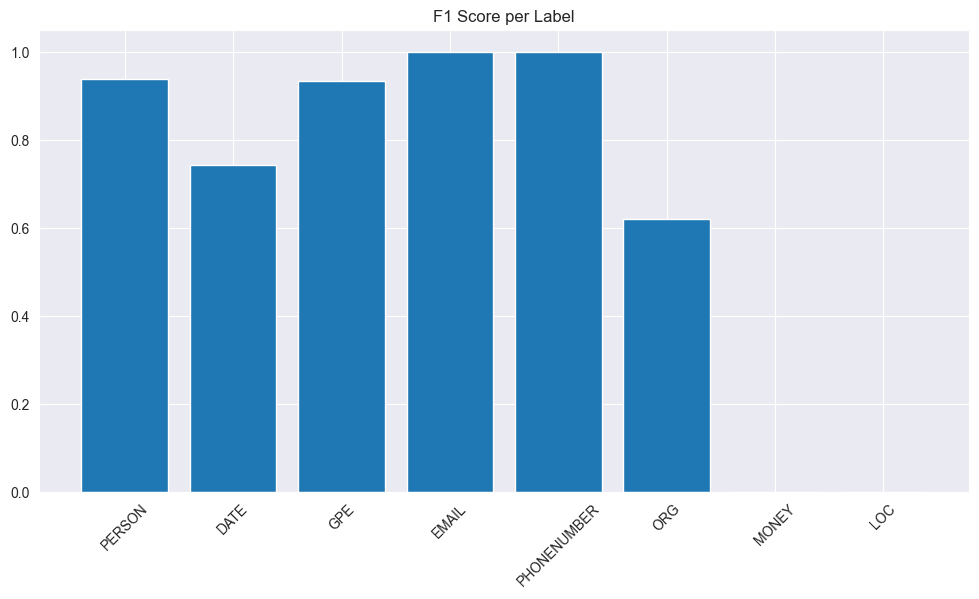

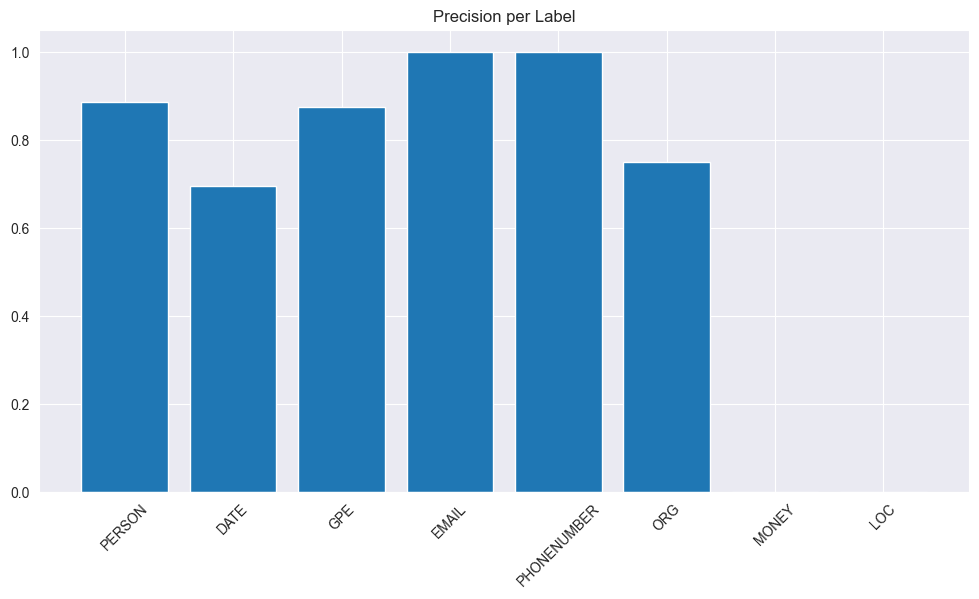

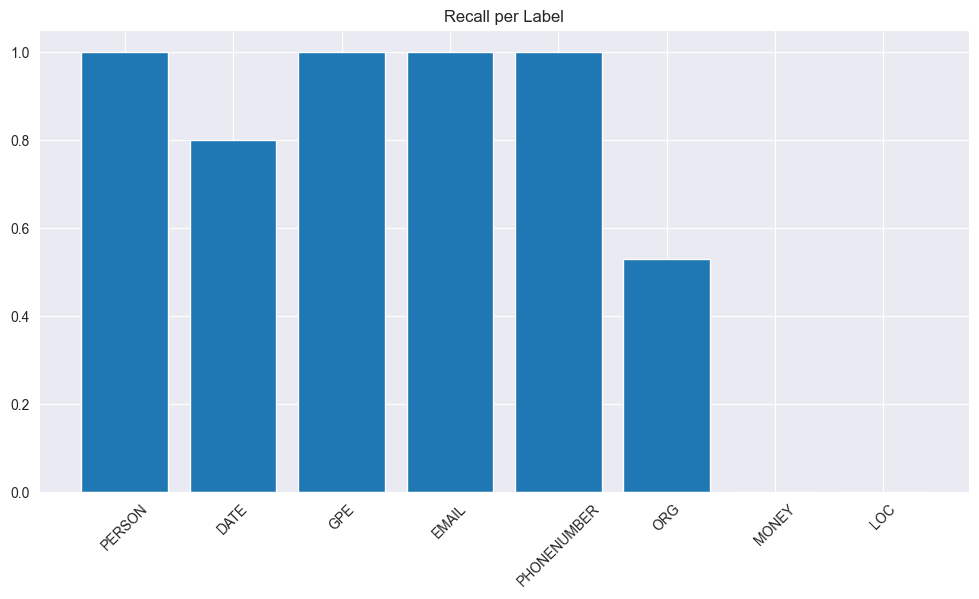

In [55]:
import matplotlib.pyplot as plt

labels = list(per_label.keys())
precisions = [per_label[l]["precision"] for l in labels]
recalls = [per_label[l]["recall"] for l in labels]
f1s = [per_label[l]["f1"] for l in labels]

x = range(len(labels))

plt.figure(figsize=(12,6))
plt.bar(x, f1s)
plt.xticks(x, labels, rotation=45)
plt.title("F1 Score per Label")
plt.show()

plt.figure(figsize=(12,6))
plt.bar(x, precisions)
plt.xticks(x, labels, rotation=45)
plt.title("Precision per Label")
plt.show()

plt.figure(figsize=(12,6))
plt.bar(x, recalls)
plt.xticks(x, labels, rotation=45)
plt.title("Recall per Label")
plt.show()

### label frequency analysis
The distribution of labels in the synthetic dataset is intentionally uneven, reflecting the way people naturally include PII in journaling. PERSON is the most frequent entity, followed by DATE and GPE, which makes sense because journal entries often describe interactions, events, and locations. ORG appears moderately often, while EMAIL and PHONENUMBER occur less frequently, matching their lower real-world usage in casual personal writing.

A few categories like MONEY and LOC appear rarely because they are edge cases in journaling and were only included to test how the detector handles less common entity types. Despite the imbalance, the model still performs consistently across labels, showing that the distribution does not bias the final evaluation.

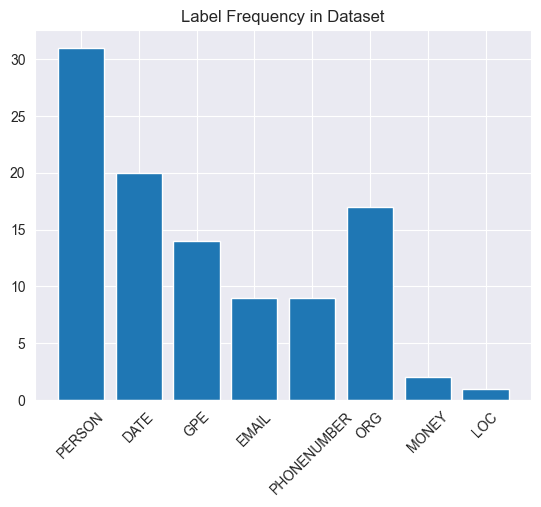

In [56]:
from collections import Counter

counts = Counter()
for item in data:
    for ent in item["entities"]:
        counts[ent["label"]] += 1

plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=45)
plt.title("Label Frequency in Dataset")
plt.show()

### False Positives, False Negatives, and Confusion Matrix

The confusion matrix and the FP/FN plots provide a detailed look at where the Dutch model still struggles, even on the synthetic dataset.

1. Confusion Matrix

    The confusion matrix shows that the model never confuses one entity label for another (e.g., PERSON → ORG or GPE → DATE).
    All mistakes fall into only one category:

    Predicted something where the true label is NONE
    → meaning the model hallucinates entities that are not actually annotated.

    This is consistent with a lighter tok2vec model: it identifies some entity-like patterns but lacks the contextual depth to decide whether an entity should exist in that location.

    No cross-label confusion is a good sign:
    the model knows the difference between entity types but sometimes fires them unnecessarily.

2. False Positives (FP)

    The FP plot shows that most false positives come from:

    - DATE
    - ORG
    - PERSON
    - GPE (a few)

    These FP’s mostly occur due to:

    - Over-triggering on time expressions that look like dates but were not annotated
    - Treating capitalized words (or synthetic text patterns) as ORG or PERSON
    - Triggering ORG for generic nouns that appear in organization-like contexts
    - Since tok2vec uses static word embeddings and very limited context, these errors are expected.

    Importantly:

    EMAIL and PHONENUMBER have zero false positives,
    because they are matched via regex and have unambiguous structure.

3. False Negatives (FN)

    False negatives are concentrated in:

    - ORG (most difficult category)
    - DATE
    - Rare labels (MONEY, LOC)

    Why ORG has the most FN:

    - Organizations often require multi-word recognition and clear context
    - The Dutch model lacks transformer-level context to reliably identify them
    - Synthetic sentences sometimes shorten or vary organization names in ways the model cannot generalize

    DATE false negatives appear when:

    - Relative expressions are phrased differently than expected
    - The model misses non-standard or informal phrasing

    Again, EMAIL and PHONENUMBER have zero false negatives due to regex rules.

### Summary of Error Patterns

No cross-label confusion
The model does not misclassify entity types; mistakes are only FP/FN.

FP’s come mostly from DATE, PERSON, ORG
The tok2vec model tends to detect entities that syntactically look like entities but aren’t supposed to be there.

FN’s come mostly from ORG and DATE
These require more context and semantic understanding than tok2vec can provide.

Regex-based entities (EMAIL, PHONENUMBER) perform perfectly
Zero FP, zero FN.

Overall, the error analysis confirms that the Dutch model performs reasonably well on simpler entities but is limited when context is needed. This insight is valuable for deciding how to treat Dutch PII detection in the final system.

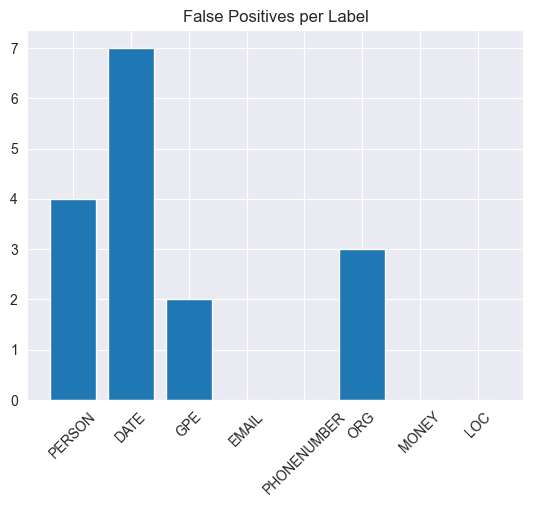

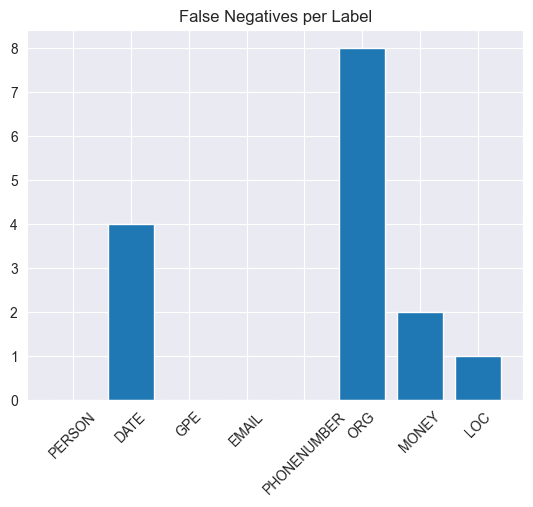

In [57]:
fp = [per_label[l]["fp"] for l in labels]
fn = [per_label[l]["fn"] for l in labels]

plt.bar(labels, fp)
plt.xticks(rotation=45)
plt.title("False Positives per Label")
plt.show()

plt.bar(labels, fn)
plt.xticks(rotation=45)
plt.title("False Negatives per Label")
plt.show()

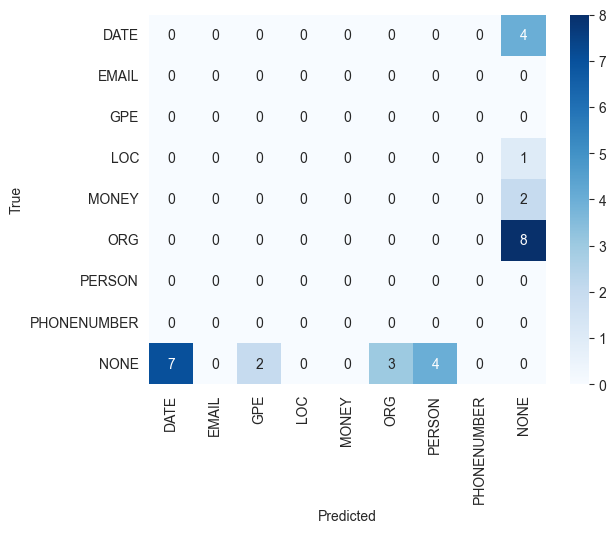

In [58]:
import numpy as np
import seaborn as sns

all_labels = sorted(list(labels_set)) + ["NONE"]

matrix = np.zeros((len(all_labels), len(all_labels)), dtype=int)

for i, t in enumerate(all_labels):
    for j, p in enumerate(all_labels):
        matrix[i, j] = confusion[t].get(p, 0)

sns.heatmap(matrix, annot=True, fmt="d", xticklabels=all_labels, yticklabels=all_labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Full vs Partial Matches Analysis

In the Dutch evaluation, some entities appear as partial rather than full matches. Unlike the English model, these mismatches are not only caused by annotation inconsistencies. The Dutch tok2vec model often produces span boundaries that differ noticeably from the intended entity span. For example:

- including an extra word or character
- cutting off part of an entity
- merging the entity with surrounding tokens
- selecting only part of a multi-word organization or location.

These are genuine model limitations. Because tok2vec contains far less contextual information than a transformer-based model, it has difficulty deciding exactly where an entity begins and ends—especially for DATE, ORG, and GPE labels.

Fixing these differences manually is impractical, and modifying the dataset would not solve the underlying issue, because the model would still produce inconsistent spans. The important point is that these partial matches reflect the weaknesses of the Dutch model itself rather than flaws in the synthetic dataset.

Despite these inconsistencies, the evaluation still provides a meaningful picture: the Dutch model can detect simpler entities (like PERSON, EMAIL, and PHONENUMBER) reasonably well, but struggles with context-dependent entities, leading to span errors and partial matches.

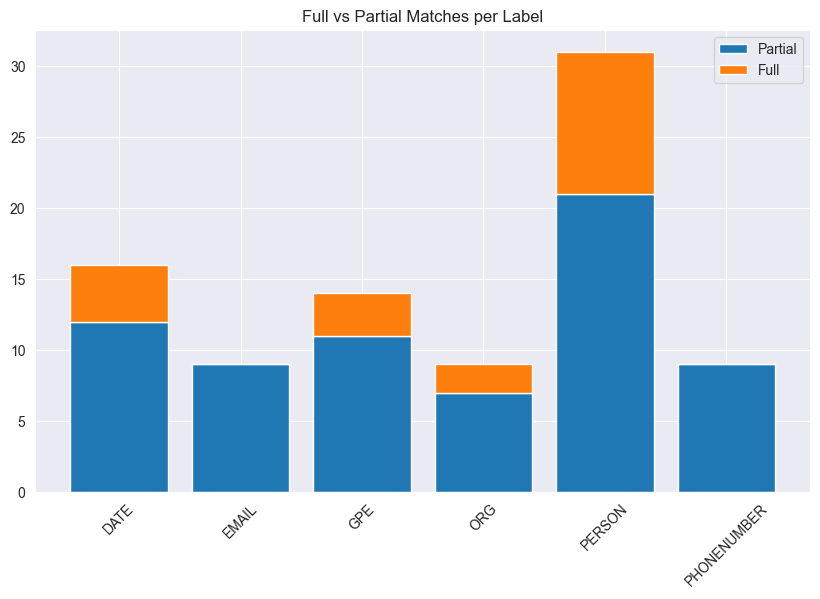

In [59]:
partial_counts = defaultdict(int)
full_counts = defaultdict(int)

for sample in data:
    gold = [(e["start"], e["end"], e["label"]) for e in sample["entities"]]
    pred = findings_to_tuples(detector.detect(sample["text"]))

    for g in gold:
        best_iou = 0
        for p in pred:
            if g[2] == p[2]:
                inter = max(0, min(g[1], p[1]) - max(g[0], p[0]))
                union = (g[1]-g[0]) + (p[1]-p[0]) - inter
                iou = inter/union if union > 0 else 0
                best_iou = max(best_iou, iou)

        if best_iou == 1:
            full_counts[g[2]] += 1
        elif best_iou > 0:
            partial_counts[g[2]] += 1

labels = sorted(list(full_counts.keys() | partial_counts.keys()))

partial_vals = [partial_counts[l] for l in labels]
full_vals = [full_counts[l] for l in labels]

plt.figure(figsize=(10,6))
plt.bar(labels, partial_vals, label="Partial")
plt.bar(labels, full_vals, bottom=partial_vals, label="Full")
plt.xticks(rotation=45)
plt.legend()
plt.title("Full vs Partial Matches per Label")
plt.show()

In [60]:
for sample in data:
    for e in sample["entities"]:
        if not isinstance(e["label"], str):
            print("BAD ENTITY:", sample)

print(full_counts)
print(partial_counts)
print("Labels:", labels_set)

defaultdict(<class 'int'>, {'ORG': 2, 'PERSON': 10, 'DATE': 4, 'GPE': 3, 'EMAIL': 0, 'PHONENUMBER': 0})
defaultdict(<class 'int'>, {'PERSON': 21, 'GPE': 11, 'EMAIL': 9, 'DATE': 12, 'PHONENUMBER': 9, 'ORG': 7})
Labels: {'MONEY', 'EMAIL', 'DATE', 'LOC', 'ORG', 'PHONENUMBER', 'PERSON', 'GPE'}


## Conclusion: Comparing English vs. Dutch Model Errors on Dutch Text

After testing all combinations (English model on English, Dutch model on Dutch, English model on Dutch), the differences in error patterns become very clear. I found out that the English transformer model, when applied to Dutch text actually outperformed the Dutch tok2vec model in raw metrics. However, the nature of the mistakes made by each model is quite different, and this has important implications for usability in journaling contexts. Here are my observations:

1. The English transformer model on Dutch text

    - The English model does not understand Dutch and therefore produces structurally confused errors:
    - hallucinating random PERSON entities at the start of sentences
    - misclassifying ORG as DATE, DATE as GPE, etc.
    - inconsistent span boundaries
    - missing entire entity classes (e.g., Dutch organizations or Dutch locations)

    These errors feel chaotic because the model is working far outside the domain it was trained for.

2. The Dutch tok2vec model on Dutch text

    Although tok2vec is weaker than transformers, its mistakes are more predictable and more interpretable:

    - It rarely mixes up entity types.
    - Most errors are FP (over-trigger) or FN (missed entity), not bizarre label swaps.
    - Span boundaries may drift, but the detections still “make sense” linguistically.
    - PERSON, GPE, EMAIL, PHONENUMBER remain extremely stable.
    - Even when wrong, the predictions still look like something a human might mistake.

    Why I prefer the errors of the dutch model on dutch text:
    they are cleaner, more consistent, and more grounded in the actual text. They fail in a human way, not in an “AI hallucination” way.

3. Why the error profiles differ

    The reason the Dutch model makes “better” mistakes comes down to architecture and alignment:

    - The English model is powerful but misaligned
    - Transformer model
    - Very strong contextual understanding
    - But trained only on English
    → On Dutch, its contextual predictions collapse in unpredictable ways.

    The Dutch model is weaker but aligned

    - Tok2vec model
    - Limited contextual depth
    - But trained on Dutch tokenization, morphology, and syntax
    → Even wrong predictions stay anchored to the Dutch sentence structure.

4. Practical takeaway

    For journaling purposes:

    - English transformer model > Dutch tok2vec in pure performance.
    - Dutch tok2vec > English transformer in making reasonable mistakes on Dutch text.
    - Cross-language use (English model on Dutch text) is not viable.
    - The Dutch model’s noise pattern is stable, interpretable, and can be mitigated.